In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os

# set paths/create objects

cp1 = day-0

cp2 = day-n

In [3]:
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171121_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171204_No Obstacles_s.mat'

cp1 = CortProcessor(cp1_path)
cp2 = CortProcessor(cp2_path)

cca_object = CCAProcessor(cp1, cp2)

this is filipe data i belive
this is filipe data i belive
should be good to align
(6945, 25)
(6945, 5)
(6945, 31)
(6945, 5)


# some testing to check gait indices

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
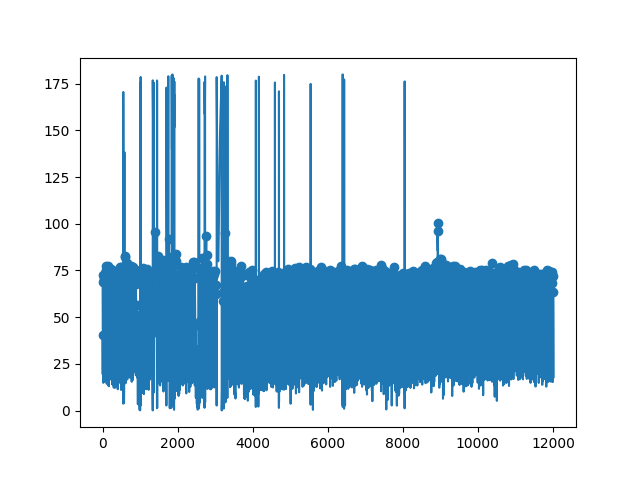

In [4]:
cp1_limbfoot = np.squeeze(cp1.data['angles'])[:,1]
peaks = np.squeeze(cp1.gait_indices)
x = np.arange(cp1_limbfoot.shape[0])

fig, ax = plt.subplots()
ax.plot(x, cp1_limbfoot)
ax.scatter(x[peaks], cp1_limbfoot[peaks])

# Getting PCA dimensions

In [5]:
#dimensions is lower of PCA95%
temp, nada, nada = cca_object.apply_PCA()
lowest_num_dimensions = temp
print(lowest_num_dimensions)

22


# storing day-n raw (unaligned, unprocessed) data as test sets

In [6]:
#get unprocessed day2 neural data as test set
test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions)))
test_y = np.squeeze(np.array(cp2.data['angles']))

test_x_format, test_y_format = format_data(test_x, test_y)

#scaled version
scaler = StandardScaler()
test_x_scale = scaler.fit_transform(test_x)

test_x_format_scale, nada = format_data(test_x_scale, test_y)

In [7]:
#subsampling list, percent of total data
subsample_list = [.05, .1, .2, .5, 1.0]

# getting day0 decoder
apply PCA, and then train wiener filter.
also get a day0-scaled-weights-decoder

In [8]:
#get day0 decoder weights, scaled + unscaled versions

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(lowest_num_dimensions))
print(np.average(nada, 1)[1])

X_tempy =cp1.apply_PCA(lowest_num_dimensions)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=[X_scale])

print(np.average(nada, 1)[1])

0.4379999999999999
0.4379999999999999


# getting JUST-PCA decoder
we subsample day-n data, apply PCA, and then train a wiener filter on it to spit out a decoder. Then we try decoder on the day2-test set

In [9]:
pca_decoder = []

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)
    
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    pca_decoder.append(temp_h)

# getting CCA scores + CCA scores inputing 10 folds before

In [10]:
cca_decoder_scores = []
cca_transformers=[]
new_cca_decoder_scores=[]
for i in range(len(subsample_list)):
    sub_x1, sub_y1, sub_x2, sub_y2 = cca_object.subsample(percent = subsample_list[i])
    
    nada, pca_sub_x1, pca_sub_x2 = cca_object.apply_PCA(cp1_x = sub_x1, cp2_x = sub_x2, preset_num_components=lowest_num_dimensions)
    temp_cca_transformer, nada = cca_object.apply_CCA(cp1_x = pca_sub_x1, cp2_x = pca_sub_x2, preset_num_components = lowest_num_dimensions)
    nada, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
    temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
    
    cca_transformers.append(temp_cca_transformer)
    temp_x_format, nada = format_data(temp_x, test_y)
    predic = test_wiener_filter(temp_x_format, day0_decoder)
    
    pca_sub_x1_format, nada = format_data(pca_sub_x1, sub_y1)
    pca_sub_x2_format, nada = format_data(pca_sub_x2, sub_y2)
    
    #temp_cca_transformer_format, nada = cca_object.apply_CCA(cp1_x = pca_sub_x1_format, cp2_x = pca_sub_x2_format, preset_num_components = lowest_num_dimensions)
    #nada, test_x_cca_space_format = temp_cca_transformer_format.transform(test_x_format, test_x_format)
    #new_temp_x_format = temp_cca_transformer_format.inverse_transform(test_x_cca_space_format)
    #new_predic = test_wiener_filter(new_temp_x_format, day0_decoder)
    
    cca_transformers.append(temp_cca_transformer)
    cca_decoder_scores.append(vaf(test_y_format[:,1], predic[:,1]))
    #new_cca_decoder_scores.append(vaf(test_y_format[:,1], new_predic[:,1]))
print(cca_decoder_scores)

/home/diya/anaconda3/envs/rat-fes/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/diya/anaconda3/envs/rat-fes/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


[-0.28, -0.89, -0.76, -0.35, 0.25]
[-0.26, -0.28, -0.06, 0.11, 0.42]


# regression fit

In [29]:
r_decoder = []

for i in range(len(subsample_list)-1):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = np.squeeze(cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x))
    number = sub_x[0].shape[0]
    nada, diya_cca = cca_transformers[i].transform(test_x[:number,:], test_x[:number,:])
    nada, sub_x_cca_space = cca_transformers[i].transform(sub_x_pca, sub_x_pca)
    temp_x = cca_transformers[i].inverse_transform(sub_x_cca_space)
    diya_x = cca_transformers[i].inverse_transform(diya_cca)
    
    scaler = StandardScaler()
    sub_x_pca_scale = scaler.fit_transform(temp_x)
    sub_x_pca_scale_format, sub_y_format = format_data(sub_x_pca_scale, np.squeeze(sub_y))
    diya_x_format, sub_y_format = format_data(diya_x, sub_y[0])
    predic = test_wiener_filter(sub_x_pca_scale_format, day0_decoder_scale)
    diya_predic = test_wiener_filter(diya_x_format, day0_decoder_scale)
    print(vaf(sub_y_format[:,1], predic[:,1]))
    print(vaf(sub_y_format[:,1], diya_predic[:,1]))

    wpost = regression_fit(b0=day0_decoder_scale, x=sub_x_pca_scale, y=np.squeeze(sub_y))
    r_decoder.append(wpost)

-0.32
-352.13
-0.07
-582.36
-0.79
-733.15
-0.79
-872.51


In [31]:
test_x.shape

(7500, 22)

In [15]:
fixed_decoder_scores=[]
pca_decoder_scores=[]
r_decoder_scores=[]

for i in range(len(subsample_list)):
    temp_y = test_wiener_filter(test_x_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, pca_decoder[i])
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format_scale, r_decoder[i])
    r_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

In [16]:
print(fixed_decoder_scores)
print(pca_decoder_scores)
print(cca_decoder_scores)
print(r_decoder_scores)

[-0.68, -0.68, -0.68, -0.68, -0.68]
[-3.64, -0.31, 0.17, 0.49, 0.64]
[-0.28, -0.89, -0.76, -0.35, 0.25]
[-2.24, -0.9, -0.16, 0.11, -0.62]
